In [1]:
import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt

from scipy          import stats

from scipy                   import optimize
from scipy.integrate         import quad
from scipy.optimize          import minimize
from scipy.optimize          import BFGS
from scipy.optimize          import Bounds
from scipy.optimize          import NonlinearConstraint

$$p_b(E|s)=s(E-c) + r$$

$$c = (a + b)/2 $$

$$r = 1/(b-a) $$

$$p_s(E|\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}e^{-(E-\mu)^2/(2\sigma^2)} $$


$$p(E|\mu_s, \mu_b, s, \mu, \sigma) = \frac{(\mu_s+\mu_b)^n}{n!} e^{-(\mu_s+\mu_b)} \left( \frac{\mu_s}{\mu_s+\mu_b}p_s(E|\mu, \sigma) +  \frac{\mu_b}{\mu_s+\mu_b}p_b(E|s) \right) $$

## RANDOM DATA GENERATION

### LINEAR

In [2]:
# linear 
class linear(stats._distn_infrastructure.rv_continuous):
    
    def _rvs(self, s):
        a, b = self.a  , self.b
        c, r = (a+b)/2., 1/(b-a)

        F = np.random.random(self._size)
        
        if   -(r-s*c)/s>a : e = -(r-s*c)/s - (((r-s*c)/s)**2 + 2*(F + a*(r-s*c + a*s/2))/s)**0.5
        elif -(r-s*c)/s<b : e = -(r-s*c)/s + (((r-s*c)/s)**2 + 2*(F + a*(r-s*c + a*s/2))/s)**0.5
        elif s==0: e = a + F/r
        
        return e
    
    def _pdf(self, e, s):
        a, b = self.a  , self.b
        c, r = (a+b)/2., 1/(b-a)
        return s*(e-c) + r
    
    def _argcheck(self, s):
        a, b = self.a  , self.b
        
        slim = 2/(b-a)**2
        
        ok = -slim<= s <= slim
        
        return ok

In [3]:
a, b = -1, 1
slim = 2/(b-a)**2

s = -0.3


lrv    = linear(a=a, b=b);
lrvval = lrv.rvs(s=s, size=1000);

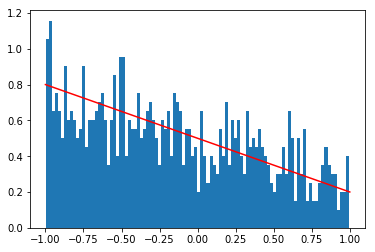

In [4]:
es = np.linspace(a, b, 1000)

plt.hist(lrvval, 100, density=True);
plt.plot(es, lrv.pdf(es, s=s), c='r');

### GAUSSIAN

In [5]:
#gauss
mu, sig = 0, 0.1

grv    = stats.norm(loc=mu, scale=sig);
grvval = grv.rvs(size=1000);

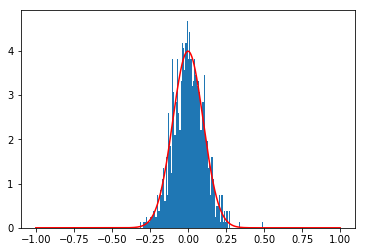

In [6]:
es = np.linspace(a, b, 1000)

plt.hist(grvval, 100, density=True);
plt.plot(es, grv.pdf(es), c='r');

In [7]:
stats.norm.fit(grvval)

(0.0024258438185420657, 0.10125722896201383)

### LINEAR + GAUSSIAN 

In [8]:
class photopeak(stats.rv_continuous):
    
    def _rvs(self, mus, mub, mu, sig, s):
        a, b = self.a, self.b
        
        lrv    = linear(a=a, b=b).rvs(s=s, size=int(mub))
        grv    = stats.norm(loc=mu, scale=sig).rvs(size=int(mus))
        
        return np.array([*grv, *lrv])
    
    def _pdf(self, e, mus, mub, mu, sig, s):
        a, b = self.a, self.b
        
        p = (mub/(mus+mub)*linear(a=a, b=b).pdf(e, s=s[0]) + mus/(mus+mub)*stats.norm(loc=mu[0], scale=sig[0]).pdf(e))
        
        return p
    
    def _argcheck(self, mus, mub, mu, sig, s):
        
        okg = (sig>=0)
        okl = linear(a=self.a, b=self.b)._argcheck(s=s)
        okm = (mus>0)&(mub>0)
        
        return okg & okl & okm

In [9]:
a, b = 380e3, 430e3
slim = 2/(b-a)**2

mus, mub, s, mu, sig = 1e3, 1e3, slim/10., 400e3, 3e3

lgrv = photopeak(a=a, b=b)
lgrvval = lgrv.rvs(mus=mus, mub=mub, mu=mu, sig=sig, s=s, size=mus+mub)

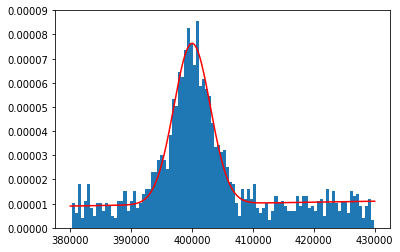

In [10]:
es = np.linspace(a, b, 1000)

plt.hist(lgrvval, 100, density=True);
plt.plot(es, lgrv.pdf(es, mus=mus, mub=mub, mu=mu, sig=sig, s=s), c='r');

## Covariance matrix estimate

$$ \hat{ (V^{-1})_{ij} } = - \frac{\partial^2 \log L(\theta)}{\partial \theta_i \partial \theta_j} |_{\theta = \hat{\theta}}  $$

In [11]:
def ll_func(data, lims):
    E = data
    n = len(E)
    
    a, b = lims
    c, r = (a+b)/2., 1/(b-a)
    slim = 2./(b-a)**2.
    
    def ll(x):
        p = stats.poisson.pmf(mu=x[0]+x[1], k=n)*pdf(x)
        constraints = np.array([(p<0).any(), x[0]<0, x[1]<0, x[2]<-slim, x[2]>slim])
        
        if constraints.any():
            return np.inf
        else:
            return -np.log(p).sum()
    
    
    def cov(x):
        mus, mub = x[0], x[1]
        f = mus/(mus+mub)
        
        p = pdf(x)
        
        mud, sigd = jac_s(x)
        sb        = jac_b(x)

        musp   =  mub/(mus+mub)**2*(fs(x)-fb(x))/p
        mubp   = -mus/(mus+mub)**2*(fs(x)-fb(x))/p
        sp   = (1-f)*sb   /p
        mup  =  f    *mud /p
        sigp =  f    *sigd/p
        
        
        A = np.array([[(musp*musp).sum(), (musp*mubp).sum(), (musp*sp).sum(), (musp*mup).sum(), (musp*sigp).sum()],
                      [(mubp*musp).sum(), (mubp*mubp).sum(), (mubp*sp).sum(), (mubp*mup).sum(), (mubp*sigp).sum()],
                      [  (sp*musp).sum(),   (sp*mubp).sum(),   (sp*sp).sum(),   (sp*mup).sum(),   (sp*sigp).sum()],
                      [ (mup*musp).sum(),  (mup*mubp).sum(),  (mup*sp).sum(),  (mup*mup).sum(),  (mup*sigp).sum()],
                      [(sigp*musp).sum(), (sigp*mubp).sum(), (sigp*sp).sum(), (sigp*mup).sum(), (sigp*sigp).sum()]])
        
        b = -n/(mus+mub)**2
        B = np.array([[b, b, 0, 0, 0],
                      [b, b, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0]])
        
        C = der2(x)
        
        covinv = -(B -A + C)
        
        return np.linalg.inv(covinv)
    
    
    def der2(x):
        mus, mub = x[0], x[1]
        f = mus/(mus+mub)
        
        p = pdf(x)
        
        mud, sigd = jac_s(x)
        sb        = jac_b(x)

        mu2p, musig2p, sig2p = der2_s(x)
        
        mus2p    =    -2*mub*(fs(x)-fb(x))/(mus+mub)**3
        mub2p    =     2*mus*(fs(x)-fb(x))/(mus+mub)**3
        musmub2p = (mus-mub)*(fs(x)-fb(x))/(mus+mub)**3
        
        cs =  mub/(mus+mub)**2
        cb = -mus/(mus+mub)**2
        
        D2 = np.array([[   (mus2p/p).sum(), (musmub2p/p).sum(), -(cs*sb/p).sum(),    cs*(mud/p).sum(),   (cs*sigd/p).sum()],
                       [(musmub2p/p).sum(),    (mub2p/p).sum(), -(cb*sb/p).sum(),    cb*(mud/p).sum(),   (cb*sigd/p).sum()],
                       [  -cs*(sb/p).sum(),   -cb*(sb/p).sum(),                0,                   0,                   0],
                       [  cs*(mud/p).sum(),   cb*(mud/p).sum(),                0,    f*(mu2p/p).sum(), f*(musig2p/p).sum()],
                       [ cs*(sigd/p).sum(),  cb*(sigd/p).sum(),                0, f*(musig2p/p).sum(),   f*(sig2p/p).sum()]])
        return D2
    
    def pdf(x):
        mus, mub = x[0], x[1]
        return mus/(mus+mub)*fs(x) + mub/(mus+mub)*fb(x)
    
    def fb(x):
        s = x[2]
        return s*(E-c) + r
    
    def jac_b(x):
        return E-c
    
    def fs(x):
        mu, sig = x[3], x[4]
        #A, _ = quad(gauss, a, b, args=(mu, sig))
        A = sig*(2*np.pi)**(1/2.)
        return (1/A)*gauss(E, mu, sig)
    
    def jac_s(x):
        mu, sig = x[3], x[4]
    
        muder  = fs(x)*(E-mu)/sig**2
        sigder = fs(x)*(-1/sig + (E-mu)**2/sig**3)
    
        return np.array([muder, sigder])
    
    
    def der2_s(x):
        
        mu, sig = x[3], x[4]
    
        muder  = fs(x)*(E-mu)/sig**2
        sigder = fs(x)*(-1/sig + (E-mu)**2/sig**3)
        
        muder2    = muder*(E-mu)/sig**2 + fs(x)*(-1/sig**2)
        sigder2   = sigder*(-1/sig + (E-mu)**2/sig**3) + fs(x)*(1/sig**2 -3*(E-mu)**2/sig**4)
        musigder2 =  muder*(-1/sig + (E-mu)**2/sig**3) + fs(x)*(-2*(E-mu)/sig**3)
        
        return np.array([muder2, musigder2, sigder2])
    

    def gauss(E, mu, sig):
        return np.e**(-(E-mu)**2/(2*sig**2))

    return ll, cov

In [16]:
a, b = 380e3, 430e3
slim = 2/(b-a)**2

mus, mub, s, mu, sig = 7000, 3000, -slim/2., 400e3, 3e3

E = photopeak(a=a, b=b).rvs(mus=mus, mub=mub, mu=mu, sig=sig, s=s)
ll, cov = ll_func(E, [a, b])

x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])

res = minimize(ll, x0, method='powell',
                   options={'disp':True, 'maxiter':1e2, 'ftol':1e-15})

Optimization terminated successfully.
         Current function value: 156710.453612
         Iterations: 15
         Function evaluations: 1568


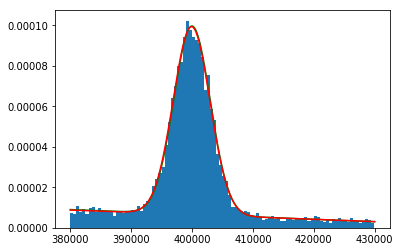

In [17]:
es = np.linspace(a, b, 1000)

plt.hist(E, 100, density=True);
plt.plot(es, photopeak(a=a, b=b).pdf(es, mus=mus, mub=mub, mu=mu, sig=sig, s=s), c='green');
mus, mub, s, mu, sig = res.x
plt.plot(es, photopeak(a=a, b=b).pdf(es, mus=mus, mub=mub, mu=mu, sig=sig, s=s), c='r');

In [18]:
res.x

array([ 7.04422209e+03,  2.95577765e+03, -3.85745474e-10,  3.99925532e+05,
        3.02542960e+03])

In [19]:
x0

array([  5000.        ,   5000.        ,      0.        , 400246.85995158,
         7973.79236841])

## Probing covariance matrix consistency

In [20]:
a, b = 380e3, 430e3
slim = 2/(b-a)**2

mus, mub, s, mu, sig = 700, 300, -slim/2., 400e3, 3e3

musp = stats.poisson.rvs(mu=mus)
mubp = stats.poisson.rvs(mu=mub)
E = photopeak(a=a, b=b).rvs(mus=musp, mub=mubp, mu=mu, sig=sig, s=s)
ll, cov = ll_func(E, [a, b])

x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])

res = minimize(ll, x0, method='powell',
                   options={'disp':True, 'ftol':1e-15, 'maxiter':1e2})

mus, mub, s, mu, sig =res.x
print()
print('Real values:', mus, mub, s, mu, sig)

Optimization terminated successfully.
         Current function value: 14393.016202
         Iterations: 12
         Function evaluations: 1343

Real values: 701.973491284584 292.02651194632136 -4.606437374434028e-10 399956.302058401 2885.993162010468


In [22]:
df = pd.DataFrame(columns=['mus', 'mub', 's', 'mu', 'sig'])

i=0
n=1e3 #number of experiments
while i<n:
    musp = stats.poisson.rvs(mu=mus)
    mubp = stats.poisson.rvs(mu=mub)
    E = photopeak(a=a, b=b).rvs(mus=musp, mub=mubp, mu=mu, sig=sig, s=s)
    ll, _ = ll_func(E, [a, b])

    x0 = np.array([.5*len(E), .5*len(E), 0, np.mean(E), np.std(E)])
    
    res = minimize(ll, x0, method='powell',
                    options={'disp':False, 'ftol':1e-15, 'maxiter':1e2})
    x =res.x
    df = df.append({'mus':x[0], 'mub':x[1], 's':x[2], 'mu':x[3], 'sig':x[4]}, ignore_index=True)
    i+=1

In [23]:
df.cov()

,mus,mub,s,mu,sig
mus,9.192331e+02,-1.615071e+02,2.014552e-10,-2.780888e+02,6.445396e+02
mub,-1.615071e+02,4.769425e+02,-1.362416e-10,1.125035e+02,-7.738958e+02
s,2.014552e-10,-1.362416e-10,5.494144e-21,-2.223740e-10,9.282993e-10
mu,-2.780888e+02,1.125035e+02,-2.223740e-10,1.623059e+04,-1.109470e+03
sig,6.445396e+02,-7.738958e+02,9.282993e-10,-1.109470e+03,1.246211e+04


In [24]:
cov([mus, mub, s, mu, sig])

array([[ 9.06151389e+02, -2.04178001e+02,  2.47747459e-10,
        -1.76288606e+02,  9.11557323e+02],
       [-2.04178001e+02,  4.96204618e+02, -2.47747522e-10,
         1.76288651e+02, -9.11557555e+02],
       [ 2.47747459e-10, -2.47747522e-10,  5.72116130e-21,
        -9.04096074e-10,  1.07385878e-09],
       [-1.76288606e+02,  1.76288651e+02, -9.04096074e-10,
         1.65703973e+04, -1.02437154e+03],
       [ 9.11557323e+02, -9.11557555e+02,  1.07385878e-09,
        -1.02437154e+03,  1.37300500e+04]])

In [26]:
covar = cov([mus, mub, s, mu, sig])
#covar = df[(df['mus']>1e2)&(df['mus']<1e3)].cov()

In [27]:
vals = df

smus = covar[0,0]
#smus = covar['mus']['mus']
smub = covar[1,1]
#smub = covar['mub']['mub']
ss   = covar[2,2]
smu  = covar[3,3]
ssig = covar[4,4]

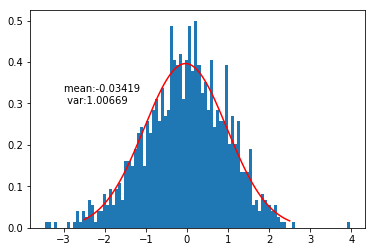

In [30]:
r = (mus-vals['mus'])/smus**0.5

loc, scale = stats.norm.fit(r)

plt.hist(r, 100, density=True);
x=np.linspace(-2.5, 2.5, 1000);
plt.plot(x, stats.norm.pdf(x,loc, scale), c='r');

plt.text(-3, 0.3, f'mean:{round(loc,5)} \n var:{round(scale,5)}');

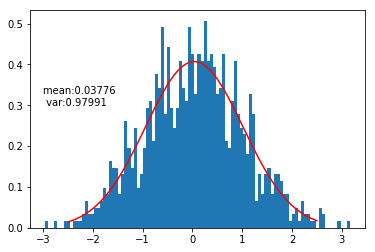

In [31]:
r = (mub-vals['mub'])/smub**0.5

loc, scale = stats.norm.fit(r)

plt.hist(r, 100, density=True);
x=np.linspace(-2.5, 2.5, 1000);
plt.plot(x, stats.norm.pdf(x,loc, scale), c='r');

plt.text(-3, 0.3, f'mean:{round(loc,5)} \n var:{round(scale,5)}');

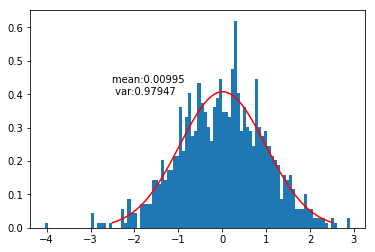

In [32]:
r = (s-vals['s'])/ss**0.5

loc, scale = stats.norm.fit(r)

plt.hist(r, 100, density=True);
x=np.linspace(-2.5, 2.5, 1000);
plt.plot(x, stats.norm.pdf(x,loc, scale), c='r');

plt.text(-2.5, 0.4, f'mean:{round(loc,5)} \n var:{round(scale,5)}');

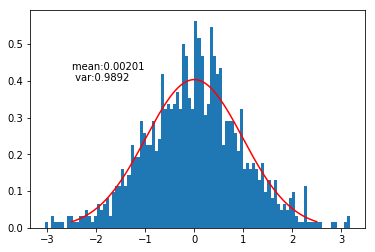

In [33]:
r = (mu-vals['mu'])/smu**0.5

loc, scale = stats.norm.fit(r)

plt.hist(r, 100, density=True);
x=np.linspace(-2.5, 2.5, 1000);
plt.plot(x, stats.norm.pdf(x,loc, scale), c='r');

plt.text(-2.5, 0.4, f'mean:{round(loc,5)} \n var:{round(scale,5)}');

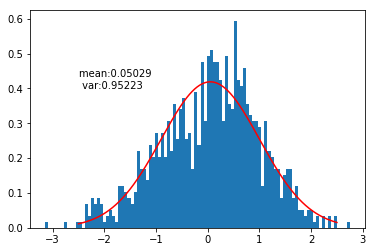

In [34]:
r = (sig-vals['sig'])/ssig**0.5

loc, scale = stats.norm.fit(r)

plt.hist(r, 100, density=True);
x=np.linspace(-2.5, 2.5, 1000);
plt.plot(x, stats.norm.pdf(x,loc, scale), c='r');

plt.text(-2.5, 0.4, f'mean:{round(loc,5)} \n var:{round(scale,5)}');

In [35]:
#comprobation
nus = 2
nub = 5

ns = stats.poisson.rvs(mu=nus, size=int(1e3))
nb = stats.poisson.rvs(mu=nub, size=int(1e3))

n=ns+nb

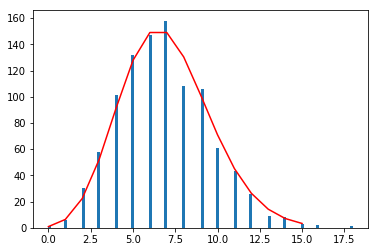

In [36]:
plt.hist(n, bins=100);
x = range(0,16)
plt.plot(x, 1e3*stats.poisson.pmf(mu=nus+nub, k=x), c='r');